<a href="https://colab.research.google.com/github/shihmujan/classs/blob/main/cat_vs_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gdown
import zipfile 
import os 

def zip_list(file_path):
    zf = zipfile.ZipFile(file_path, 'r')
    zf.extractall()

url = 'https://drive.google.com/u/2/uc?id=16CxoW8TF_FA2pKbf6wYx_O-bdcEZ1fXp&export=download&confirm=t'
output = "cat_dog.zip"
gdown.download(url, output)

file_path = "cat_dog.zip"
zip_list(file_path)

Downloading...
From: https://drive.google.com/u/2/uc?id=1lRFo-ENH38EUcj8XCWq40vUklLZwoLXg&export=download&confirm=t
To: /content/cat_dog.zip
100%|██████████| 798M/798M [00:07<00:00, 112MB/s] 


In [ ]:
!pip install efficientnet_pytorch
!pip install lime

In [ ]:
import glob
from itertools import chain
import os
import random
import zipfile
from efficientnet_pytorch import EfficientNet
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms , models
from tqdm import tqdm

In [ ]:
resume = True

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_workers = 0
batch_size = 25

TRAIN = 'cats_vs_dogs/train'
VALID = 'cats_vs_dogs/validation'
PATH1 = 'cats_vs_dogs/test'

Size=(256,256)

image_size = (224,224)
train_transforms = transforms.Compose(
    [
     transforms.Resize(image_size),
     transforms.RandomResizedCrop(image_size),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
    ]
)

valid_transforms = transforms.Compose(
    [
     transforms.Resize(image_size),
     transforms.RandomResizedCrop(image_size),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
    ]
)

test_transforms = transforms.Compose(
    [
     transforms.Resize(image_size),
     transforms.ToTensor(),
    ]
)
transform = transforms.Resize(image_size)


train_data = datasets.ImageFolder(TRAIN, transform=train_transforms)
valid_data = datasets.ImageFolder(VALID,transform=valid_transforms)
test_data = datasets.ImageFolder(PATH1, transform=test_transforms)
class_dic = train_data.class_to_idx
class_dic = {v: k for k, v in class_dic.items()}
print(train_data.class_to_idx)
print(valid_data.class_to_idx)

train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers,shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size,  num_workers=num_workers,shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size,  num_workers=num_workers)

{'cat': 0, 'dog': 1}
{'cat': 0, 'dog': 1}


In [ ]:
model = EfficientNet.from_pretrained('efficientnet-b5').to(device)
num_feature = model._fc.in_features
model.fc = nn.Linear(num_feature, 2).to(device)

if resume: 
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('checkpoint/ckpt.pth')
    model.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

Loaded pretrained weights for efficientnet-b5
==> Resuming from checkpoint..


In [ ]:
optimizer = optim.Adam(params = model.parameters(),lr =0.01)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95)
criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    epoch_val_accuracy = 0
    epoch_val_loss = 0
    ValidLoader = tqdm(valid_loader)
    for data, label in ValidLoader:
        data = data.to(device)
        label = label.to(device)

        val_output = model(data)
        val_loss = criterion(val_output, label)

        acc = (val_output.argmax(dim=1) == label).float().mean()
        epoch_val_accuracy += acc / len(valid_loader)
        epoch_val_loss += val_loss / len(valid_loader)

        ValidLoader.set_postfix(loss=float(val_loss.item()), lr=float(optimizer.state_dict()['param_groups'][0]['lr']))

    print('val_accuracy : {}, val_loss : {}'.format(epoch_val_accuracy, epoch_val_loss))

100%|██████████| 120/120 [01:16<00:00,  1.58it/s, loss=0.00677, lr=0.01]

val_accuracy : 0.966666579246521, val_loss : 0.07836990803480148


In [ ]:
def batch_predict(images):
    model.eval()
    
    batch = torch.stack(tuple(test_transforms(Image.fromarray(i)) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()


def show_image(dataset, class_dic=None, lab=None, pred=None, row=2, col=5):
    fig, ax = plt.subplots(nrows=row, ncols=col, sharex='all', sharey='all', ) # 一张图片有5行5列个子图
    fig.set_figheight(15)
    fig.set_figwidth(15)
    ax = ax.flatten()

    for idx,img in enumerate(dataset):
        if idx == row * col:
            break

        ax[idx].imshow(img)
        if class_dic != None and pred == None:
            ax[idx].set_title("label:"+ class_dic[lab[idx]])
        elif class_dic != None and pred != None:
            result = 'None'
            if pred == lab:
                result = 'Correct!'
            elif pred != lab:
                result = 'Error!'
            ax[idx].set_title("label:" + class_dic[lab[idx]] + "\npredict:" + class_dic[pred[idx]] + '\n' + result)

        ax[0].set_xticks([])
        ax[0].set_yticks([])

    plt.tight_layout()  # 自动紧凑布局
    plt.show()

In [ ]:
row, col = 2,5
test_data = datasets.ImageFolder(PATH1, transform=transform)

def predict_image(img):
  model.eval()
  model.to(device)
  img = Image.fromarray(img)
  img = test_transforms(img)[np.newaxis,:,:,:].to(device)
  pred = model(img)
  cls = int(pred.argmax(dim=1))
  return cls

def get_random_img_lab(test_data, row=2, col=5):
  random_list = []
  for i in range(row*col):
    random_list.append(random.randint(0,len(test_data)))
  random_list.sort()


  image_list = []
  label_list = []
  pred_list = []
  for num in random_list:
    img = np.array(test_data[num][0])
    image_list.append(img)
    label_list.append(test_data[num][1])
    pred_list.append(predict_image(img))

  return image_list,label_list,pred_list

image_list,label_list,pred_list = get_random_img_lab(test_data)

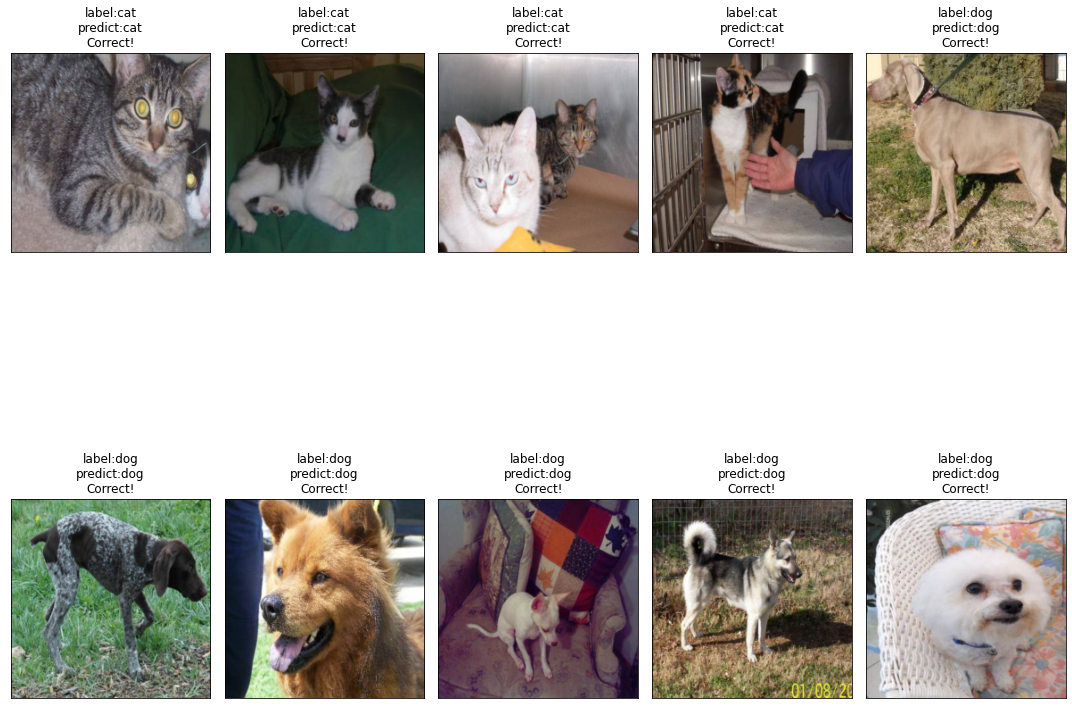

In [ ]:
show_image(image_list, class_dic, label_list, pred_list)

In [ ]:
error_list = []
for idx, (img,lab) in enumerate(tqdm(test_data)):
  img = np.array(img)
  pred = predict_image(img)
  if lab != pred:
    error_list.append((img, lab, pred))

100%|██████████| 3000/3000 [03:02<00:00, 16.47it/s]


In [ ]:
print(len(error_list))

23


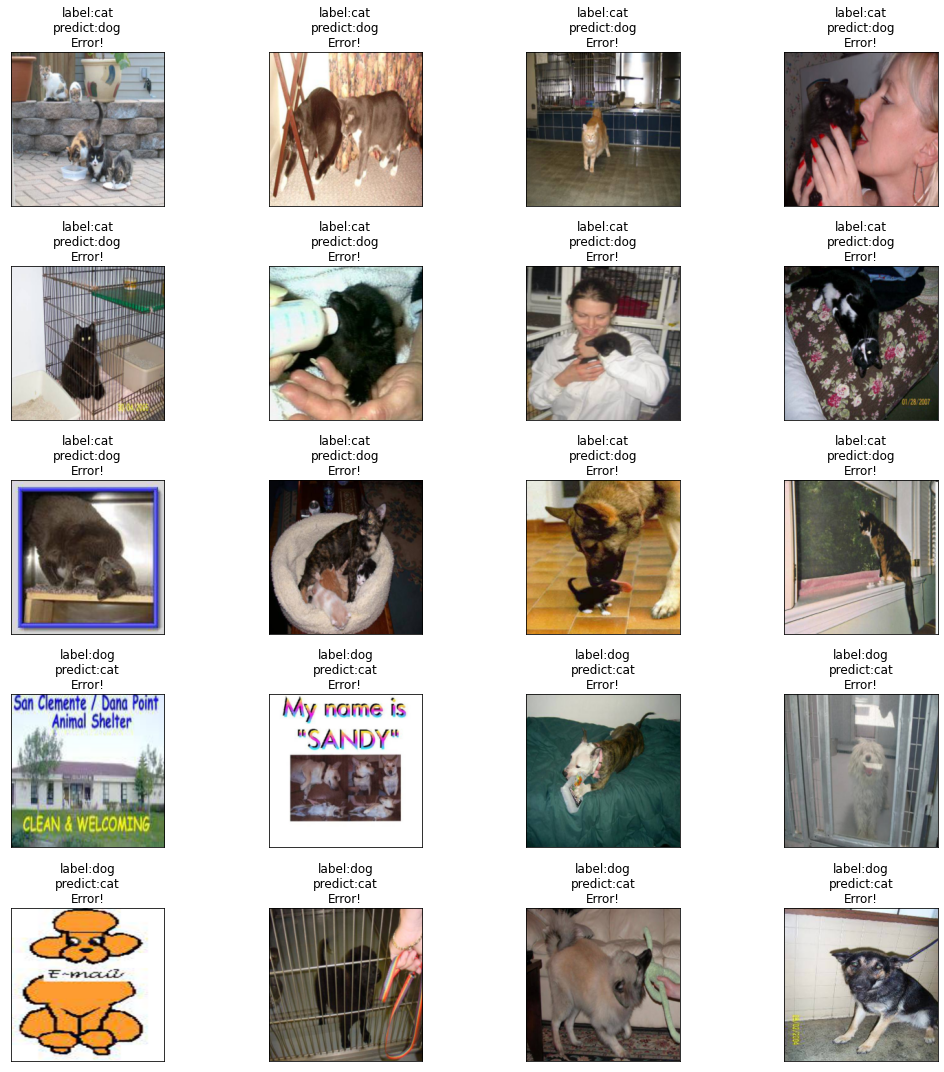

In [ ]:
error_img = []
error_lab = []
error_pre = []

for i,l,p in error_list:
  error_img.append(i)
  error_lab.append(l)
  error_pre.append(p)
show_image(error_img, class_dic, error_lab, error_pre, 5, 4)

In [ ]:
def show_explain(exp):
  img_list = []
  temp, mask = exp.get_image_and_mask(lab, positive_only=True, num_features=1, hide_rest=True)
  img1 = mark_boundaries(temp / 255.0, mask)
  temp, mask = exp.get_image_and_mask(lab, positive_only=True, num_features=1, hide_rest=False)
  img2 = mark_boundaries(temp / 255.0, mask)
  temp, mask = exp.get_image_and_mask(lab, positive_only=False, num_features=1, hide_rest=False)
  img3 = mark_boundaries(temp / 255.0, mask)
  temp, mask = exp.get_image_and_mask(lab, positive_only=False, num_features=4, hide_rest=False)
  img4 = mark_boundaries(temp / 255.0, mask)

  return [img1,img2,img3,img4]

  0%|          | 0/200 [00:00<?, ?it/s]

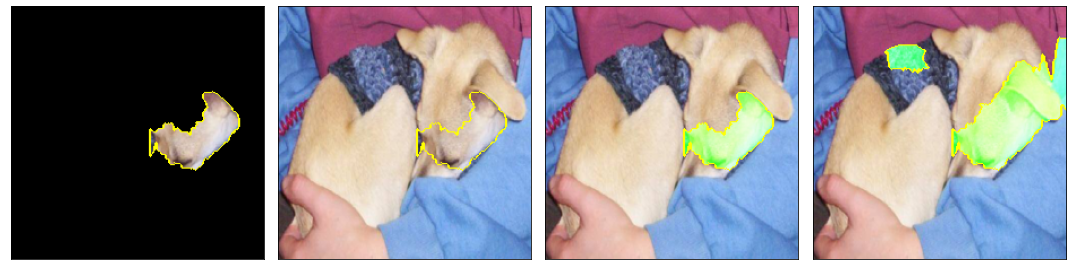

label: dog  predict: dog


In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

image_list,label_list,pred_list = get_random_img_lab(test_data,1,1)
img = image_list[0]
lab = label_list[0]
pred = pred_list[0]

explainer = lime_image.LimeImageExplainer()
explain = explainer.explain_instance(img, batch_predict, top_labels=2, hide_color=0,num_samples=200)
img_list = show_explain(explain)
show_image(img_list,row=1,col=4)
print('label:',class_dic[lab],' predict:',class_dic[pred])


  0%|          | 0/200 [00:00<?, ?it/s]

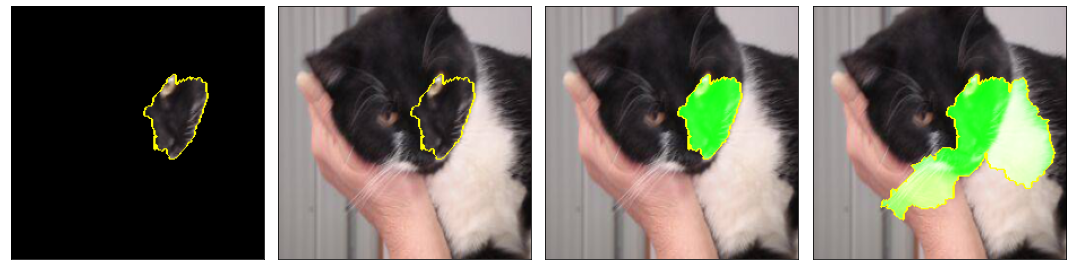

label: cat  predict: cat


In [ ]:
image_list,label_list,pred_list = get_random_img_lab(test_data,1,1)
img = image_list[0]
lab = label_list[0]
pred = pred_list[0]

explainer = lime_image.LimeImageExplainer()
explain = explainer.explain_instance(img, batch_predict, top_labels=2, hide_color=0,num_samples=200)
#------------------------------------------------------------------------------------------------------------------
img_list = show_explain(explain)
show_image(img_list,row=1,col=4)
print('label:',class_dic[lab],' predict:',class_dic[pred])

  0%|          | 0/200 [00:00<?, ?it/s]

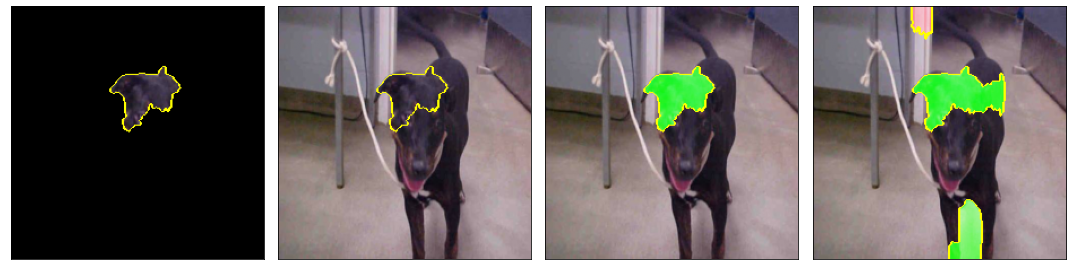

label: dog  predict: dog


In [ ]:
image_list,label_list,pred_list = get_random_img_lab(test_data,1,1)
img = image_list[0]
lab = label_list[0]
pred = pred_list[0]

explainer = lime_image.LimeImageExplainer()
explain = explainer.explain_instance(img, batch_predict, top_labels=2, hide_color=0,num_samples=200)
#------------------------------------------------------------------------------------------------------------------
img_list = show_explain(explain)
show_image(img_list,row=1,col=4)
print('label:',class_dic[lab],' predict:',class_dic[pred])

  0%|          | 0/200 [00:00<?, ?it/s]

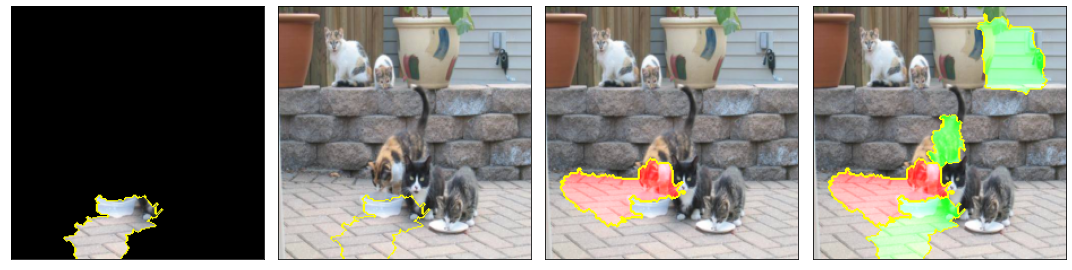

label: cat  predict: dog


In [ ]:
idx = 0
img = error_img[idx]
lab = error_lab[idx]
pred = error_pre[idx]

explainer = lime_image.LimeImageExplainer()
explain = explainer.explain_instance(img, batch_predict, top_labels=2, hide_color=0,num_samples=200)
#------------------------------------------------------------------------------------------------------------------
img_list = show_explain(explain)
show_image(img_list,row=1,col=4)
print('label:',class_dic[lab],' predict:',class_dic[pred])

  0%|          | 0/200 [00:00<?, ?it/s]

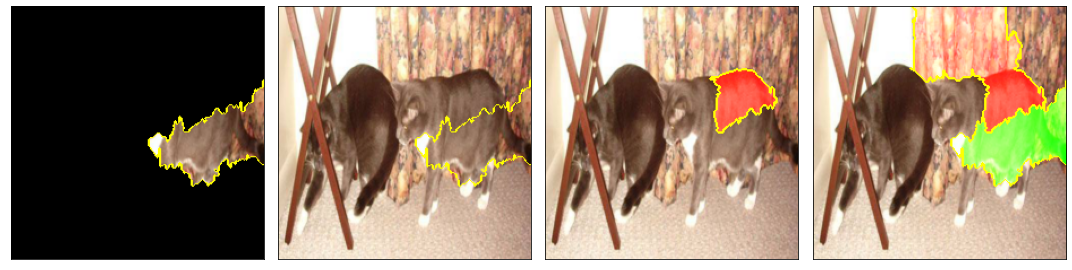

label: cat  predict: dog


In [ ]:
idx = 1
img = error_img[idx]
lab = error_lab[idx]
pred = error_pre[idx]

explainer = lime_image.LimeImageExplainer()
explain = explainer.explain_instance(img, batch_predict, top_labels=2, hide_color=0,num_samples=200)
#------------------------------------------------------------------------------------------------------------------
img_list = show_explain(explain)
show_image(img_list,row=1,col=4)
print('label:',class_dic[lab],' predict:',class_dic[pred])